# Example usage of the `torchTextClassifiers` library

*Warning*

*`torchTextClassifiers` library is still under active development. Have a
regular look to <https://github.com/inseefrlab/torchTextClassifiers> for
latest information.*

To download the latest (development) version of the library, you can use
```bash
uv add git+https://github.com/InseeFrLab/torchTextClassifiers
```
or, if you prefer using `pip`:
```bash
pip install git git+https://github.com/InseeFrLab/torchTextClassifiers
```


In [35]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from notebooks.utils import categorize_surface, clean_and_tokenize_df
from torchTextClassifiers import ModelConfig, TrainingConfig, torchTextClassifiers
from torchTextClassifiers.dataset import TextClassificationDataset
from torchTextClassifiers.model import TextClassificationModel, TextClassificationModule
from torchTextClassifiers.model.components import (
    AttentionConfig,
    CategoricalVariableNet,
    ClassificationHead,
    TextEmbedder,
    TextEmbedderConfig,
)
from torchTextClassifiers.tokenizers import HuggingFaceTokenizer, WordPieceTokenizer
from torchTextClassifiers.utilities.plot_explainability import (
    map_attributions_to_char,
    map_attributions_to_word,
    plot_attributions_at_char,
    plot_attributions_at_word,
    figshow
)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load and preprocess data

In that guide, we propose to illustrate main package functionalities
using that `DataFrame`:

In [2]:
import pandas as pd

df = pd.read_parquet("https://minio.lab.sspcloud.fr/projet-ape/data/08112022_27102024/naf2008/split/df_train.parquet")
df

,apet_finale,libelle,CJ,NAT,TYP,SRF,CRT
0,6202A,CONSEIL EN SYSTEMES ET LOGICIELS INFORMATIQUES,NaN,NaN,X,0.0,P
1,9529Z,petit bricolage,NaN,NaN,X,0.0,P
2,4332A,"Menuiserie intérieure, Agencement",5710,14,M,0.0,P
3,6831Z,Agent commercial en immobilier,NaN,NaN,R,0.0,NaN
4,6820A,Location meublé d'un appartement dans le centr...,NaN,NaN,L,0.0,P
...,...,...,...,...,...,...,...
1693384,9609Z,Autres services personnels n.c.a.,NaN,NaN,NaN,0.0,NaN
1693385,9700Z,Activités des ménages en tant qu'employeurs de...,NaN,NaN,NaN,0.0,NaN
1693386,9810Z,Activités indifférenciées des ménages en tant ...,NaN,NaN,NaN,0.0,NaN
1693387,9820Z,Activités indifférenciées des ménages en tant ...,NaN,NaN,NaN,0.0,NaN


It contains an extract from the French business register (SIRENE). The `apet_finale` column contains the activity code - out target - in the French version of the [NACE nomenclature](https://ec.europa.eu/eurostat/web/products-manuals-and-guidelines/-/ks-ra-07-015). The text to classify is the `libelle` column, which contains a short description of the activity.

Other columns are additional, **categorical** features that will be also used as inputs to the model.


In [3]:
df

,apet_finale,libelle,CJ,NAT,TYP,SRF,CRT
0,6202A,CONSEIL EN SYSTEMES ET LOGICIELS INFORMATIQUES,NaN,NaN,X,0.0,P
1,9529Z,petit bricolage,NaN,NaN,X,0.0,P
2,4332A,"Menuiserie intérieure, Agencement",5710,14,M,0.0,P
3,6831Z,Agent commercial en immobilier,NaN,NaN,R,0.0,NaN
4,6820A,Location meublé d'un appartement dans le centr...,NaN,NaN,L,0.0,P
...,...,...,...,...,...,...,...
1693384,9609Z,Autres services personnels n.c.a.,NaN,NaN,NaN,0.0,NaN
1693385,9700Z,Activités des ménages en tant qu'employeurs de...,NaN,NaN,NaN,0.0,NaN
1693386,9810Z,Activités indifférenciées des ménages en tant ...,NaN,NaN,NaN,0.0,NaN
1693387,9820Z,Activités indifférenciées des ménages en tant ...,NaN,NaN,NaN,0.0,NaN


In [4]:
categorical_features = [ "CJ", "NAT", "TYP", "SRF", "CRT"]
text_feature = "libelle"
y = "apet_finale"

Right now, the model requires the label (variable y) to be a numerical
variable. If the label variable is a text variable, we recommend using
Scikit Learn’s
[LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)
to convert into a numeric variable. Using that function will give user
the possibility to get back labels from the encoder after running
predictions.

In [5]:
encoder = LabelEncoder()
df["apet_finale"] = encoder.fit_transform(df["apet_finale"])

The function `clean_and_tokenize_df` requires special `DataFrame`
formatting:

-   First column contains the processed text (str)
-   Next ones contain the **“encoded”** categorical (discrete) variables in
    **int format**, as required by torchTextClassifiers.

In [6]:
df, _ = clean_and_tokenize_df(df, text_feature="libelle")
X = df[["libelle", "CJ", "NAT", "TYP", "CRT", "SRF"]].values
y = df["apet_finale"].values

df

,libelle,CJ,NAT,TYP,SRF,CRT,apet_finale
0,CONSEIL EN SYSTEMES ET LOGICIELS INFORMATIQUES,135,14,12,0,1,550
1,petit bricolage,135,14,12,0,1,720
2,"Menuiserie intérieure, Agencement",69,3,7,0,1,355
3,Agent commercial en immobilier,135,14,10,0,0,580
4,Location meublé d'un appartement dans le centr...,135,14,6,0,1,578
...,...,...,...,...,...,...,...
1693384,Autres services personnels n.c.a.,135,14,8,0,0,727
1693385,Activités des ménages en tant qu'employeurs de...,135,14,8,0,0,728
1693386,Activités indifférenciées des ménages en tant ...,135,14,8,0,0,729
1693387,Activités indifférenciées des ménages en tant ...,135,14,8,0,0,730


In [7]:
X.shape, y.shape

((1693389, 6), (1693389,))

We now split the data into train, val and test sets, as done classically in machine learning tasks.


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

# Let's dive into the different components of a text classification model

## Tokenizer

In [9]:
text = X_train[:, 0].tolist()  # extract the text column as a list

You can directly load a pretrained tokenizer from Hugging Face. But you won't have control over its vocabulary size or other parameters!

In [10]:
tokenizer = HuggingFaceTokenizer.load_from_pretrained("google-bert/bert-base-uncased")
print("This tokenizer outputs tensors of size ", tokenizer.tokenize(text[0]).input_ids.shape)
print("The tokens are here ", tokenizer.tokenizer.convert_ids_to_tokens(tokenizer.tokenize(text[0]).input_ids.squeeze(0)))
print("The total number of tokens is ", tokenizer.vocab_size)

This tokenizer outputs tensors of size  torch.Size([1, 12])
The tokens are here  ['[CLS]', 'tr', '##ava', '##ux', 'd', "'", 'isolation', 'ex', '##ter', '##ieu', '##re', '[SEP]']
The total number of tokens is  30522


Or you can train your own tokenizer from scratch.

In [11]:
tokenizer = WordPieceTokenizer(vocab_size=5000, output_dim=125)
tokenizer.train(text)
print("This tokenizer outputs tensors of size ", tokenizer.tokenize(text[0]).input_ids.shape)
print("The tokens are here ", tokenizer.tokenizer.convert_ids_to_tokens(tokenizer.tokenize(text[0]).input_ids.squeeze(0)))
print("The total number of tokens is ", tokenizer.vocab_size)




This tokenizer outputs tensors of size  torch.Size([1, 125])
The tokens are here  ['[SEP]', 'travaux', 'd', "'", 'isolation', 'exterieure', '[CLS]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[

## The PyTorch Dataset

To train a text classification model using PyTorch, you need to create a Dataset object that will handle the data loading and preprocessing. The `TextClassificationDataset` class from the `torchTextClassifiers` library can be used for this purpose.

In [12]:
train_dataset = TextClassificationDataset(
    texts=X_train[:, 0].tolist(),
    categorical_variables=X_train[:, 1:].tolist(),
    tokenizer=tokenizer,
    labels=y_train,
)
train_dataset[0]

("TRAVAUX D'ISOLATION EXTERIEURE ", [135, 3, 7, 1, 0], np.int64(352))

And then, you can create a ``DataLoader`` to iterate over the dataset during training. The DataLoader, via its `collate_fn` function, handles nicely the raw text and outputs tokenized, padded PyTorch tensors for immediate model ingestion.

In [13]:
train_dataloader = train_dataset.create_dataloader(
            batch_size=256,
            num_workers=12,
            shuffle=False,
        )
batch = next(iter(train_dataloader))

print("Input IDs shape: ", batch["input_ids"].shape)  # (batch_size, tokenizer.output_dim (=seq_length))

Input IDs shape:  torch.Size([256, 125])


## The PyTorch Model

We provide three main components for the model architecture: 

- The `TextEmbedder` class, which handles the embedding of the token ids input into dense vectors
- The `CategoricalVariableNet` class, which handles the embedding of the categorical variables
- The `ClassificationHead`, that outputs the prediction vector

Eventually, the `TextClassificationModel` class combines all these components into a single model that can be trained end-to-end.

All of these four objects inherit from the `torch.nn.Module` class, so you can use them as you would do with any PyTorch model.

### The TextEmbedder

In [14]:
### TextEmbedder parameters

# size of the vocabulary - do not change, this must match the tokenizer used. It is the number of rows in the embedding matrix
vocab_size = tokenizer.vocab_size  
padding_idx = tokenizer.padding_idx
embedding_dim = 96

### Attention parameters - Optional ! If you want to add self-attention layer
n_layers = 1
n_head = 4
n_kv_head = n_head
sequence_len = tokenizer.output_dim

# wrap them into AttentionConfig
attention_config = AttentionConfig(
    n_layers=n_layers,
    n_head=n_head,
    n_kv_head=n_kv_head,
    sequence_len=sequence_len,
)

The first component is the embedding layer. It transforms input tokens (that comes from the tokenizer) into dense vectors of dimension `embedding_dim`.

In [15]:
# wrap all TextEmbedder parameters into TextEmbedderConfig
text_embedder_config = TextEmbedderConfig(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    padding_idx=padding_idx,
    attention_config=attention_config,
)

# initialize the TextEmbedder
text_embedder = TextEmbedder(
    text_embedder_config=text_embedder_config,
)
text_embedder.init_weights()

In [16]:
text_embedder

TextEmbedder(
  (embedding_layer): Embedding(5000, 96, padding_idx=1)
  (transformer): ModuleDict(
    (h): ModuleList(
      (0): Block(
        (attn): SelfAttentionLayer(
          (c_q): Linear(in_features=96, out_features=96, bias=False)
          (c_k): Linear(in_features=96, out_features=96, bias=False)
          (c_v): Linear(in_features=96, out_features=96, bias=False)
          (c_proj): Linear(in_features=96, out_features=96, bias=False)
        )
        (mlp): MLP(
          (c_fc): Linear(in_features=96, out_features=384, bias=False)
          (c_proj): Linear(in_features=384, out_features=96, bias=False)
        )
      )
    )
  )
)

In [17]:
# test the TextEmbedder: it takes as input a tensor of token ids and outputs a tensor of embeddings

text_embedder_output = text_embedder(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])

print("TextEmbedder input: ", batch["input_ids"])
print("TextEmbedder output shape: ", text_embedder_output.shape)

TextEmbedder input:  tensor([[   3,  326,   40,  ...,    1,    1,    1],
        [   3, 1411, 1837,  ...,    1,    1,    1],
        [   3,  199,  126,  ...,    1,    1,    1],
        ...,
        [   3, 1045, 1111,  ...,    1,    1,    1],
        [   3,  387,  259,  ...,    1,    1,    1],
        [   3,  386,  296,  ...,    1,    1,    1]])
TextEmbedder output shape:  torch.Size([256, 96])


### The CategoricalVariableNet

The second component is the categorical variable layer. It transforms input ids from the encoded categorical variables into dense vectors of dimension `categorical_embedding_dims`. Depending on the type of `categorical_embedding_dims`, the output dimension will vary.

This component is of course optional: you will not use it if you don't have categorical variables in your dataset.

In [18]:
categorical_vocab_sizes = (X[:, 1:].max(axis=0) + 1).tolist()

## categorical_embedding_dims can be a list of ints (one embedding dimension per categorical variable) - then they are concatenated
# the final average will be concatenated with text embedding (in the full model)
categorical_embedding_dims = [15, 10, 10, 10, 10]
categorical_var_net = CategoricalVariableNet(
    categorical_vocabulary_sizes=categorical_vocab_sizes,
    categorical_embedding_dims=categorical_embedding_dims,
)
cat_var_net_output = categorical_var_net(batch["categorical_vars"])
print(cat_var_net_output.shape)
print("How will the categorical embedding be merged with the text one ? ", categorical_var_net.forward_type)

## it can also be None - the output dim will be text_embedding_dim that you should specify
# the final average will be ADDED TO text embedding (in the full model)
categorical_embedding_dims = None
categorical_var_net = CategoricalVariableNet(
    categorical_vocabulary_sizes=categorical_vocab_sizes,
    categorical_embedding_dims=categorical_embedding_dims,
    text_embedding_dim=embedding_dim,  # not putting this will raise an error
)
cat_var_net_output = categorical_var_net(batch["categorical_vars"])
print(cat_var_net_output.shape)
print("How will the categorical embedding be merged with the text one ? ", categorical_var_net.forward_type)


## and finally, it can be an int (the same embedding dimension for all categorical variables and then averaging)
# the final average will be concatenated with text embedding (in the full model)
categorical_embedding_dims = 25
categorical_var_net = CategoricalVariableNet(
    categorical_vocabulary_sizes=categorical_vocab_sizes,
    categorical_embedding_dims=categorical_embedding_dims,
)
cat_var_net_output = categorical_var_net(batch["categorical_vars"])
print(cat_var_net_output.shape)
print("How will the categorical embedding be merged with the text one ? ", categorical_var_net.forward_type)


torch.Size([256, 55])
How will the categorical embedding be merged with the text one ?  CategoricalForwardType.CONCATENATE_ALL
torch.Size([256, 96])
How will the categorical embedding be merged with the text one ?  CategoricalForwardType.SUM_TO_TEXT
torch.Size([256, 25])
How will the categorical embedding be merged with the text one ?  CategoricalForwardType.AVERAGE_AND_CONCAT


### The ClassificationHead

In [19]:
num_classes = int(y.max() + 1)

# as discussed above, the input dim of the classification head depends on how categorical variables are handled
if type(categorical_embedding_dims) is int or type(categorical_embedding_dims) is list:
    expected_input_dim = embedding_dim + categorical_var_net.output_dim
else:
    expected_input_dim = embedding_dim

classification_head = ClassificationHead(
    input_dim=expected_input_dim,
    num_classes=num_classes,
)

In [20]:
x_combined = torch.cat((text_embedder_output, cat_var_net_output), dim=1)
logits = classification_head(x_combined)
print("logits shape: ", logits.shape)  # (batch_size, num_classes)

logits shape:  torch.Size([256, 732])


### The TextClassificationModel

Finally, the `TextClassificationModel` class combines all these components into a single model that can be trained end-to-end.
It checks if everything connects well together (input/output dimensions) and handles the forward pass.

In [21]:
model = TextClassificationModel(
    text_embedder=text_embedder,
    categorical_variable_net=categorical_var_net,
    classification_head=classification_head,
)
model

TextClassificationModel(
  (text_embedder): TextEmbedder(
    (embedding_layer): Embedding(5000, 96, padding_idx=1)
    (transformer): ModuleDict(
      (h): ModuleList(
        (0): Block(
          (attn): SelfAttentionLayer(
            (c_q): Linear(in_features=96, out_features=96, bias=False)
            (c_k): Linear(in_features=96, out_features=96, bias=False)
            (c_v): Linear(in_features=96, out_features=96, bias=False)
            (c_proj): Linear(in_features=96, out_features=96, bias=False)
          )
          (mlp): MLP(
            (c_fc): Linear(in_features=96, out_features=384, bias=False)
            (c_proj): Linear(in_features=384, out_features=96, bias=False)
          )
        )
      )
    )
  )
  (categorical_variable_net): CategoricalVariableNet(
    (categorical_embedding_0): Embedding(136, 25)
    (categorical_embedding_1): Embedding(15, 25)
    (categorical_embedding_2): Embedding(15, 25)
    (categorical_embedding_3): Embedding(3, 25)
    (categori

In [22]:
# Takes the same input as TextEmbedder + CategoricalVarNet -> same output as ClassificationHead (logits)
model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"], categorical_vars=batch["categorical_vars"]).shape

torch.Size([256, 732])

### The TextClassificationModule

We provide a PyTorch Lightning wrapper, for easy training and checkpointing. We refer to [Lightning's doc](https://lightning.ai/docs/pytorch/stable/) for more details on how to use it.

In [23]:
import torch

module = TextClassificationModule(
    model=model,
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam,
    optimizer_params={"lr": 1e-3},
    scheduler=None,
    scheduler_params=None,
    scheduler_interval="epoch",
)
module

TextClassificationModule(
  (model): TextClassificationModel(
    (text_embedder): TextEmbedder(
      (embedding_layer): Embedding(5000, 96, padding_idx=1)
      (transformer): ModuleDict(
        (h): ModuleList(
          (0): Block(
            (attn): SelfAttentionLayer(
              (c_q): Linear(in_features=96, out_features=96, bias=False)
              (c_k): Linear(in_features=96, out_features=96, bias=False)
              (c_v): Linear(in_features=96, out_features=96, bias=False)
              (c_proj): Linear(in_features=96, out_features=96, bias=False)
            )
            (mlp): MLP(
              (c_fc): Linear(in_features=96, out_features=384, bias=False)
              (c_proj): Linear(in_features=384, out_features=96, bias=False)
            )
          )
        )
      )
    )
    (categorical_variable_net): CategoricalVariableNet(
      (categorical_embedding_0): Embedding(136, 25)
      (categorical_embedding_1): Embedding(15, 25)
      (categorical_embedding_

# `torchTextClassifiers`: a wrapper to handle them all

## Initialization

In [57]:
### Two main config objects, that mirror the parameters used above - and you're good to go !

model_config = ModelConfig(
    embedding_dim=embedding_dim,
    categorical_vocabulary_sizes=categorical_vocab_sizes,
    categorical_embedding_dims=categorical_embedding_dims,
    num_classes=num_classes,
    attention_config=attention_config,
)

training_config = TrainingConfig(
    lr=1e-3,
    batch_size=256,
    num_epochs=2,
)

ttc = torchTextClassifiers(
    tokenizer=tokenizer,
    model_config=model_config,
)

## Given those parameters, the TextClassificationModel is created internally, with the right connections between components
ttc

torchTextClassifiers(
  tokenizer = WordPieceTokenizer 
 HuggingFace tokenizer: PreTrainedTokenizerFast(name_or_path='', vocab_size=5000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'pad_token': '[PAD]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
),
  model = TextClassificationModel(
  (text_embedder): TextEmbedder(
    (embedding_layer): Embedding(5000, 96, padding_idx=1)
    (transformer): ModuleDict(
      (h): ModuleList(
        (0): Block(
          (attn): SelfAttentionL

## Training

`torchTextClassifiers` has a `.train()` method that handles the whole training process for you:

- Init of dataset and dataloaders
- Init of Lightning module
- Training with early stopping and model checkpointing
- Using Lightning's Trainer under the hood

In [ ]:
ttc.train(
    X_train=X_train,
    y_train=y_train,
    X_val=X_test,
    y_val=y_test,
    training_config=training_config,
)

## Prediction and explainability

In [66]:
ttc.pytorch_model.eval().cuda()

TextClassificationModel(
  (text_embedder): TextEmbedder(
    (embedding_layer): Embedding(5000, 96, padding_idx=1)
    (transformer): ModuleDict(
      (h): ModuleList(
        (0): Block(
          (attn): SelfAttentionLayer(
            (c_q): Linear(in_features=96, out_features=96, bias=False)
            (c_k): Linear(in_features=96, out_features=96, bias=False)
            (c_v): Linear(in_features=96, out_features=96, bias=False)
            (c_proj): Linear(in_features=96, out_features=96, bias=False)
          )
          (mlp): MLP(
            (c_fc): Linear(in_features=96, out_features=384, bias=False)
            (c_proj): Linear(in_features=384, out_features=96, bias=False)
          )
        )
      )
    )
  )
  (categorical_variable_net): CategoricalVariableNet(
    (categorical_embedding_0): Embedding(136, 25)
    (categorical_embedding_1): Embedding(15, 25)
    (categorical_embedding_2): Embedding(15, 25)
    (categorical_embedding_3): Embedding(3, 25)
    (categori

In [103]:
top_k = 3
yyy = ttc.predict(X_test[:5], top_k=top_k, explain=True)

text_idx = 0
text = X_test[text_idx, 0]
offsets = yyy["offset_mapping"][text_idx]  # seq_len, 2
attributions = yyy["attributions"][text_idx]  # top_k, seq_len
word_ids = yyy["word_ids"][text_idx]  # seq_len
predictions = yyy["prediction"][text_idx] 

In [108]:
words, word_attributions = map_attributions_to_word(attributions, text, word_ids, offsets)
char_attributions = map_attributions_to_char(attributions, offsets, text)


In [76]:
encoder.inverse_transform(np.array([predictions]).reshape(-1))

array(['8551Z', '9312Z', '8552Z'], dtype=object)

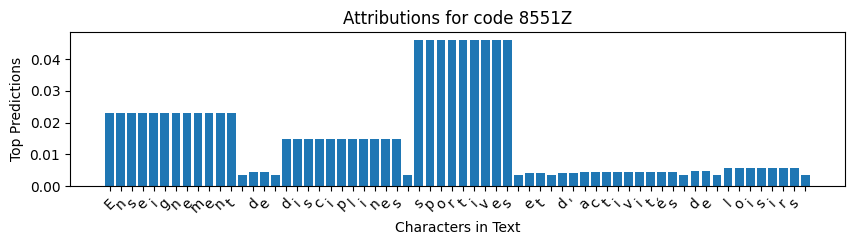

In [77]:
all_plots = plot_attributions_at_char(
    text=text,
    attributions_per_char=char_attributions,
    titles = list(map(lambda x: f"Attributions for code {x}", encoder.inverse_transform(np.array([predictions]).reshape(-1)).tolist())),
)
figshow(all_plots[0])

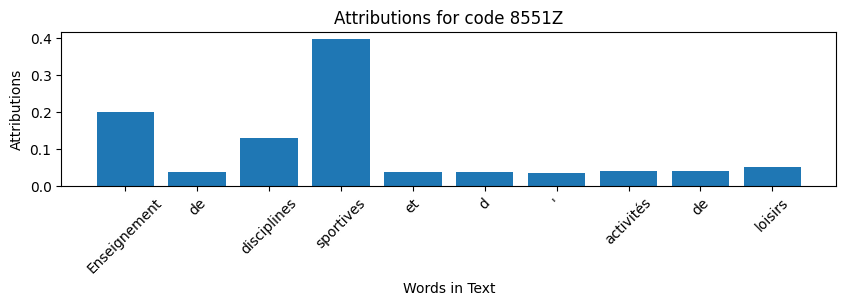

In [110]:
all_plots = plot_attributions_at_word(
    text=text,
    words=words.values(),
    attributions_per_word=word_attributions,
    titles = list(map(lambda x: f"Attributions for code {x}", encoder.inverse_transform(np.array([predictions]).reshape(-1)).tolist())),
)
figshow(all_plots[0])